In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
import torch
from bertopic import BERTopic
from hdbscan import HDBSCAN
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajaym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text):
    """
    Cleans the input text by removing encoded characters, normalizing spaces, 
    protecting specific patterns, and fixing punctuation.
    
    Args:
        text (str): The input text string to clean.

    Returns:
        str: The cleaned text string.
    """
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.replace('\xa0', ' ')
    text = text.replace('\x92', "'")
    text = text.replace('\x93', '"')
    text = text.replace('\x94', '"')
    text = re.sub(r'\\x[0-9A-Fa-f]{2}', '', text)
    text = re.sub(r'(www\.[a-zA-Z0-9-]+\.[a-zA-Z0-9]+)', r'\1_URL_', text)
    text = re.sub(r'Item\s*(\d+[A-Za-z]*)\.', r'Item_\1_', text)
    text = re.sub(r'U\.S\.', r'US_', text)
    text = re.sub(r'Inc\.', r'Inc_', text)
    text = re.sub(r'Corp\.', r'Corp_', text)
    text = re.sub(r'Dec\.', r'Dec_', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s*\.\s*', '. ', text)
    text = re.sub(r'\s*,\s*', ', ', text)
    text = re.sub(r'\s*;\s*', '; ', text)
    text = re.sub(r'\s*:\s*', ': ', text)
    text = re.sub(r'\s+([,.;:])', r'\1', text)
    text = re.sub(r'(?<=[.!?])(?=\S)', ' ', text)
    text = re.sub(r'\.+', '.', text)
    
    return text.strip()


In [ ]:
def split_sentences(text):
    """
    Splits the input text into sentences using NLTK, with additional pre- and post-processing 
    to clean text and handle special cases.

    Args:
        text (str): The input text string to split.

    Returns:
        list: A list of processed sentences.
    """
    cleaned_text = clean_text(text)
    sentences = sent_tokenize(cleaned_text)

    processed_sentences = []
    for sentence in sentences:
        sentence = sentence.replace('Item_', 'Item ').replace('_', '.')
        sentence = sentence.replace('US_', 'U.S.')
        sentence = sentence.replace('Inc_', 'Inc.')
        sentence = sentence.replace('Corp_', 'Corp.')
        sentence = sentence.replace('Dec_', 'Dec.')
        sentence = sentence.replace('_URL_', '.')
        sentence = sentence.strip()
        if len(sentence) > 5:
            processed_sentences.append(sentence)

    final_sentences = []
    i = 0
    while i < len(processed_sentences):
        current = processed_sentences[i]
        if current.endswith((';', ':')) or current.startswith(('•', '-')):
            final_sentences.append(current)
            i += 1
        elif i + 1 < len(processed_sentences) and not current.endswith(('.', '!', '?')):
            final_sentences.append(current + ' ' + processed_sentences[i + 1])
            i += 2
        else:
            final_sentences.append(current)
            i += 1

    return final_sentences


In [ ]:
def converttotext(url):
    """
    Extracts and processes the Item 1A section from a 10-K SEC filing given its URL.

    Args:
        url (str): The URL to the SEC 10-K filing.

    Returns:
        list: A list of sentences extracted from the Item 1A section.
    """

    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|3|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|3|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    # item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
    # item_7_content = BeautifulSoup(item_7_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()
    # item_7_text = item_7_content.get_text()

    sentences = split_sentences(item_1a_text)
    # sentences = split_sentences(item_7_text)
    
    return sentences

In [ ]:
target_year = 2021
industry = "OIL"

with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
    companies = json.load(read_file)

sentences = []

for company in companies:
    try:
        sentences += converttotext(company['url'])
        print(f"Company: {company['company']}, Total Sentence count: {len(sentences)}")
    except Exception as e:
        print(f"Error processing {company['company']}: {e}")

Company: SLB, Total Sentence count: 102
Company: CVX, Total Sentence count: 218
Error processing HAL: 'item1a'
Company: HES, Total Sentence count: 218
Company: TSN, Total Sentence count: 219
Company: XOM, Total Sentence count: 329
Company: RRC, Total Sentence count: 331
Company: EQT, Total Sentence count: 769
Company: OXY, Total Sentence count: 955
Company: MUR, Total Sentence count: 1235
Error processing PHM: 'item1b'
Company: SM, Total Sentence count: 1582
Company: CTRA, Total Sentence count: 1948
Company: EOG, Total Sentence count: 1948
Company: ENB, Total Sentence count: 1948
Company: VLO, Total Sentence count: 1948
Company: DVN, Total Sentence count: 2112
Company: GTE, Total Sentence count: 2336
Error processing BTCS: 'item1a'
Company: AR, Total Sentence count: 2336
Company: COP, Total Sentence count: 2530
Company: KOS, Total Sentence count: 3133
Company: CHRD, Total Sentence count: 3687
Company: MTDR, Total Sentence count: 4539
Company: KMI, Total Sentence count: 4896
Company: MP

In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

embedding_model = SentenceTransformer("nithinreddyy/finetuned-esg").to(device)
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

Using device: cuda


Batches:   0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=8,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='leaf',
    prediction_data=True
)

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    token_pattern=r"(?u)\b\w\w+\b"
)

ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=False,
    bm25_weighting=False 
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    min_topic_size=3, 
    top_n_words=10,  
    nr_topics=100 

topics, probs = topic_model.fit_transform(sentences, embeddings=embeddings)
topic_info = topic_model.get_topic_info()
topic_info.head(52)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1475,-1_operations_business_ability_financial,"[operations, business, ability, financial, res...","[This period of extreme economic disruption, l..."
1,0,198,0_risks_damage_operations_weather,"[risks, damage, operations, weather, hazards, ...",[Any of these risks could adversely affect our...
2,1,183,1_prices_oil_natural_natural gas,"[prices, oil, natural, natural gas, gas, deman...","[These factors include, but are not limited to..."
3,2,156,2_able_assurance_indemnification_terms,"[able, assurance, indemnification, terms, cont...",[We may not be entitled to contractual indemni...
4,3,143,3_unable_water_reserves_decline,"[unable, water, reserves, decline, production,...",[Unless we replace our oil and natural gas res...
5,4,141,4_delays_regulations_restrictions_hydraulic fr...,"[delays, regulations, restrictions, hydraulic ...","[Federal, state and local legislative and regu..."
6,5,131,5_covid_covid 19_19_pandemic,"[covid, covid 19, 19, pandemic, 19 pandemic, g...",[If the COVID-19 coronavirus continues to spre...
7,6,128,6_debt_indebtedness_credit_rating,"[debt, indebtedness, credit, rating, capital, ...",[A high level of indebtedness could affect our...
8,7,121,7_counterparties_obligations_financial_derivative,"[counterparties, obligations, financial, deriv...",[Derivative arrangements also expose us to the...
9,8,120,8_fracturing_hydraulic fracturing_hydraulic_re...,"[fracturing, hydraulic fracturing, hydraulic, ...",[In addition to these federal legislative and ...


In [30]:
topic_model.get_document_info(sentences)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,ITEM 1A.,66,66_item 1a_1a_url_item,"[item 1a, 1a, url, item, contents, com, com ur...","[ITEM 1A., ITEM 1A., ITEM 1A.]",item 1a - 1a - url - item - contents - com - c...,0.420319,True
1,RISK FACTORSOur operations and financial resul...,1,1_risks_business_operations_laws,"[risks, business, operations, laws, regulation...",[Any of the foregoing could adversely affect o...,risks - business - operations - laws - regulat...,1.000000,False
2,Risks Specific to our CompanyWe generate a sig...,45,45_advertising_ads_user_search,"[advertising, ads, user, search, mobile, users...","[Any changes, bugs, or technical issues in suc...",advertising - ads - user - search - mobile - u...,0.670474,False
3,We generated over 80% of total revenues from t...,32,32_revenue_approximately_derived_portion,"[revenue, approximately, derived, portion, rev...","[During the year ended December 31, 2020, two ...",revenue - approximately - derived - portion - ...,1.000000,False
4,"Many of our advertisers, companies that distri...",0,0_products_customers_adversely_demand,"[products, customers, adversely, demand, unabl...",[If we are unable to anticipate future technol...,products - customers - adversely - demand - un...,0.795045,False
...,...,...,...,...,...,...,...,...
17657,Concerns relating to the potential transmissio...,7,7_pandemic_covid 19_19_covid,"[pandemic, covid 19, 19, covid, 19 pandemic, i...",[The Covid-19 pandemic may negatively impact o...,pandemic - covid 19 - 19 - covid - 19 pandemic...,1.000000,False
17658,Certain medical device regulatory agencies hav...,-1,-1_business_products_operations_financial,"[business, products, operations, financial, re...",[Any such changes may have an adverse effect o...,business - products - operations - financial -...,0.000000,False
17659,We obtain bovine tissue only from closely cont...,34,34_components_materials_suppliers_limited number,"[components, materials, suppliers, limited num...","[Our products rely on key components, includin...",components - materials - suppliers - limited n...,0.733272,False
17660,The bovine tissue used in our pericardial tiss...,34,34_components_materials_suppliers_limited number,"[components, materials, suppliers, limited num...","[Our products rely on key components, includin...",components - materials - suppliers - limited n...,0.682601,False


In [31]:
topic_model.visualize_topics()

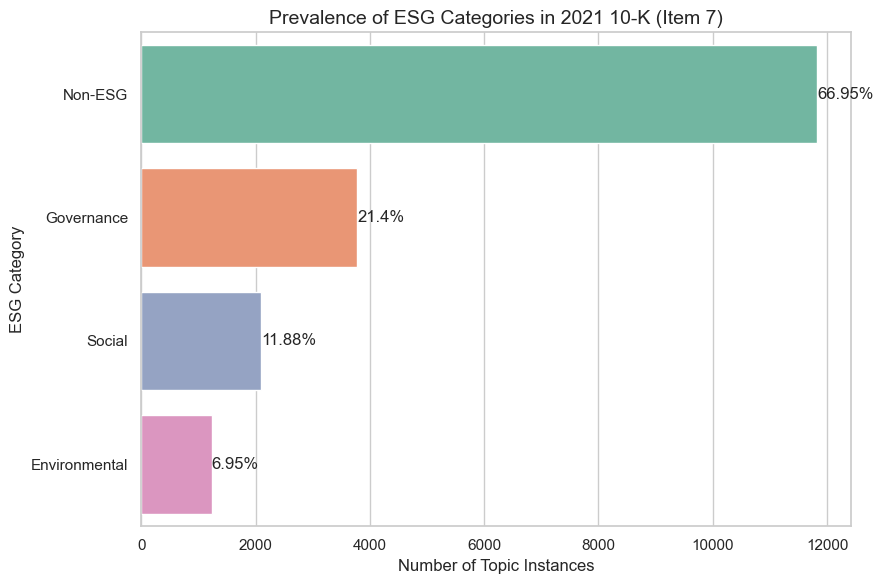


Prevalence of ESG Categories (Counts and Percentages):
               Count  Percentage
Non-ESG        11825       66.95
Governance      3779       21.40
Social          2099       11.88
Environmental   1228        6.95


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

with open('words.json', 'r') as file:
    words_data = json.load(file)

environmental_keywords = set(word.lower() for word in words_data.get('Environmental', []))
social_keywords = set(word.lower() for word in words_data.get('Social', []))
governance_keywords = set(word.lower() for word in words_data.get('Governance', []))
all_esg_keywords = environmental_keywords | social_keywords | governance_keywords


def categorize_topic(representation):
    if not isinstance(representation, list) or not representation:
        return ["Non-ESG"]
    
    words = set(word.lower() for word in representation)
    
    categories = []
    if words & environmental_keywords:
        categories.append("Environmental")
    if words & social_keywords:
        categories.append("Social")
    if words & governance_keywords:
        categories.append("Governance")
    
    return categories if categories else ["Non-ESG"]

topic_info['ESG_Categories'] = topic_info['Representation'].apply(categorize_topic)

total_counts = topic_info['Count'].sum()
category_counts = {
    'Environmental': 0,
    'Social': 0,
    'Governance': 0,
    'Non-ESG': 0
}

for _, row in topic_info.iterrows():
    count = row['Count']
    for category in row['ESG_Categories']:
        category_counts[category] += count

category_distribution = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
category_distribution['Percentage'] = (category_distribution['Count'] / total_counts * 100).round(2)
category_distribution = category_distribution.sort_values(by='Count', ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(x='Count', y=category_distribution.index, hue=category_distribution.index, data=category_distribution, palette='Set2')
for i, (count, percentage) in enumerate(zip(category_distribution['Count'], category_distribution['Percentage'])):
    plt.text(count, i, f'{percentage}%', va='center', ha='left')
plt.title(f'Prevalence of ESG Categories in {target_year} 10-K (Item 7)', fontsize=14)
plt.xlabel('Number of Topic Instances', fontsize=12)
plt.ylabel('ESG Category', fontsize=12)
plt.tight_layout()
plt.show()

print("\nPrevalence of ESG Categories (Counts and Percentages):")
print(category_distribution)

In [ ]:
import pandas as pd
import json
import os

topic_info = topic_model.get_topic_info()

with open('words.json', 'r') as file:
    words_data = json.load(file)

environmental_keywords = set(word.lower() for word in words_data.get('Environmental', []))
social_keywords = set(word.lower() for word in words_data.get('Social', []))
governance_keywords = set(word.lower() for word in words_data.get('Governance', []))
all_esg_keywords = environmental_keywords | social_keywords | governance_keywords

def categorize_esg_topic(topic_words):
    words_set = set(word.lower() for word in topic_words)
    
    if not words_set.intersection(all_esg_keywords):
        return None
    
    categories = []
    if words_set.intersection(environmental_keywords):
        categories.append("Environmental")
    if words_set.intersection(social_keywords):
        categories.append("Social")
    if words_set.intersection(governance_keywords):
        categories.append("Governance")
    
    return categories

topic_info['ESG_Categories'] = topic_info['Representation'].apply(categorize_esg_topic)

esg_topics = topic_info[topic_info['ESG_Categories'].notnull()].copy()

environmental_topics = []
social_topics = []
governance_topics = []

for _, row in esg_topics.iterrows():
    topic_data = {
        'Name': row['Name'],
        'Representation': ','.join(row['Representation']),
        'Count': row['Count'],
        'ESG_Categories': ','.join(row['ESG_Categories'])
    }
    for category in row['ESG_Categories']:
        if category == "Environmental":
            environmental_topics.append(topic_data)
        elif category == "Social":
            social_topics.append(topic_data)
        elif category == "Governance":
            governance_topics.append(topic_data)

environmental_df = pd.DataFrame(environmental_topics)
social_df = pd.DataFrame(social_topics)
governance_df = pd.DataFrame(governance_topics)

output_dir = "esg_topics"
os.makedirs(output_dir, exist_ok=True)

if not environmental_df.empty:
    environmental_df.to_csv(os.path.join(output_dir, f"environmental_topics_{industry}_{target_year}.csv"), index=False)
else:
    print("No Environmental topics found.")

if not social_df.empty:
    social_df.to_csv(os.path.join(output_dir, f"social_topics_{industry}_{target_year}.csv"), index=False)
else:
    print("No Social topics found.")

if not governance_df.empty:
    governance_df.to_csv(os.path.join(output_dir, f"governance_topics_{industry}_{target_year}.csv"), index=False)
else:
    print("No Governance topics found.")

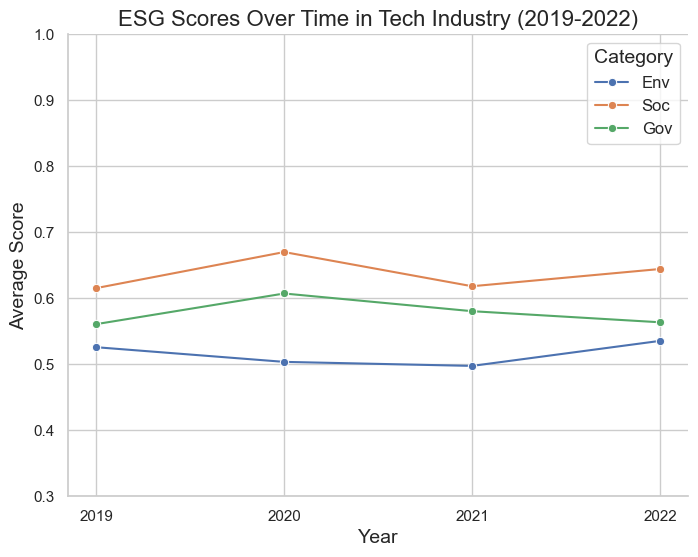

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Year': [2019, 2020, 2021, 2022],
    'Env': [0.5258, 0.5036, 0.4975, 0.5354],
    'Soc': [0.6154, 0.6700, 0.6182, 0.6443],
    'Gov': [0.5608, 0.6072, 0.5804, 0.5636]
}
df = pd.DataFrame(data)

df_melted = df.melt(id_vars='Year', value_vars=['Env', 'Soc', 'Gov'], 
                    var_name='Metric', value_name='Score')

sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_melted, x='Year', y='Score', hue='Metric', 
             marker='o')

plt.title('ESG Scores Over Time in Tech Industry (2019-2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title="Category", title_fontsize=14, fontsize=12)
plt.xticks([2019, 2020, 2021, 2022])
plt.ylim(0.3, 1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()